# **ETF Return Prediction Project**

This project aims to predict the forward **close-to-close return** for 16 ETFs using historical data.

I firstly applied a **Vector AutoRegression (VAR)** model as a baseline multivariate time-series model. Then I chose a more advanced multi-factor machine learning model **XGBoost**, to provide some better predictions.

My prediction target is:  
> Given all information up to time `t`, predict the return from `t` to `t+1` (close-to-close).

Performance is evaluated based on **cumulative cross-sectional Information Coefficient (IC)**, both in-sample and out-of-sample.

ETF symbols: ['DIA', 'IWM', 'QQQ', 'SPY', 'VXX', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI','XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']

In [215]:
# Packages
import os
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stat
import seaborn as sns
from optuna.visualization import plot_optimization_history
from xgboost.callback import EarlyStopping
from statsmodels.tsa.api import VAR
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error

# Paths
DATA_DIR = "data"
ORIGINAL_DATA_DIR = os.path.join(DATA_DIR, "original_data")
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed_data")
RESULTS_DIR = "results"
FIGURES_DIR = "figures"
MODELS_DIR = "models"

print("Hello Project")
print("\n")

Hello Project




# Section ONE: Vector Autoregression (baseline model)

In this section, I only used **VAR model**, and fed it with **daily return data** only. 

> The process includes:
> - Loading and merging ETF close prices  
> - Calculating daily returns  
> - Performing stationarity checks (ADF test)  
> - Training the VAR model  
> - Forecasting next-day returns  
> - Backtesting a simple long-short strategy

It serves as a <font color=Red>*reference benchmark*</font> for comparing with more complex models (with higher dimension features).

## Step 1: Load and Merge ETF Close Prices
In this step, I load individual ETF historical CSV files from `data/orginal_data/` folder.  
I extract the closing price columns, align on `Date`, merge them into a single DataFrame, and save in `data/processed_data/`.

In [219]:
etf_dfs = []
etf_names = []

for csv_file in os.listdir(ORIGINAL_DATA_DIR):
    if csv_file.endswith(".csv"):
        etf = csv_file.replace(".csv", "")
        etf_names.append(etf)

        df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, csv_file))
        close_col = "Close" if "Close" in df.columns else "Price"
        df = df[["Date", close_col]]
        df.columns = ["Date", etf]
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")

        etf_dfs.append(df)

merged_df = etf_dfs[0]
for df in etf_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on = "Date", how = "inner")

merged_df = merged_df.set_index("Date")
merged_df.to_csv(os.path.join(PROCESSED_DATA_DIR, "close_merged_df.csv"))

print("Includes:", etf_names)

Includes: ['XLE', 'QQQ', 'VXX', 'XLF', 'XLP', 'XLC', 'XLB', 'XLU', 'XLV', 'IWM', 'XLY', 'DIA', 'XLK', 'SPY', 'XLI', 'XLRE']


## Step 2: Calculate Daily Returns for VAR

Next, compute the daily `close-to-close percentage return` for each ETF as the input of VAR model.

In [222]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "close_merged_df.csv"), index_col = "Date", parse_dates = True, thousands = ",")
df = df.astype("float")
close_returns = df.pct_change().dropna()
close_returns.to_csv(os.path.join(PROCESSED_DATA_DIR, "return_merged_df.csv"))
print("We did it")

We did it


## Step 3: Stationarity Check and Return Visualization

Before fitting a VAR model, we should ensure that all input series are **stationary**. Thus I perform the **ADF test** on each ETF's daily return series to check for stationarity.

I also visualize the daily return series for each ETF to inspect their volatility and detect any anomalies (all save in `figures/returns/`).

In [225]:
# Augmented Dickey-Fuller Test：Check for unit roots
from IPython.display import display, HTML

results_html = "<div style='max-height: 300px; overflow-y: scroll; font-family: monospace;'>"

returns = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, "return_merged_df.csv"), index_col="Date", parse_dates=True)
etf_list = returns.columns.tolist()
count = 0

for etf in etf_list:
    result = stat.adfuller(returns[etf])
    adf_stat = f"{result[0]:.4f}"
    p_value = f"{result[1]}"
    status = "Stationary" if result[1] <= 0.05 else "Not Stationary"
    
    if status == "Stationary":
        count += 1 
        
    results_html += f"<b>{etf}</b>: ADF = {adf_stat}, p = {p_value} → {status}<br>"

results_html += "</div>"
if count == 16:
    print("All ETFs passed ADT test.") 
else:
    print("Some ETFs FAILED.")
display(HTML(results_html))

All ETFs passed ADT test.


In [227]:
os.makedirs(FIGURES_DIR, exist_ok=True)

for col in returns.columns:
    returns[col].plot(figsize=(16, 5), title=f"{col} Daily Return")
    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"returns/{col}_daily_return.png"))
    plt.close()

## Step 4.1: Build and Train VAR Model

Fit a **Vector Autoregression (VAR)** model on the daily return data.  

The optimal lag order is chosen by comparing different information criteria.

In [229]:
etf_list = returns.columns.tolist()
returns = returns.clip(lower = -0.21, upper = 0.15)
returns.index.freq = pd.infer_freq(returns.index)

training_set = returns.loc["2018-06-21":"2023-12-31"]
testing_set = returns.loc["2024-01-01":]

model = VAR(training_set)
result = model.fit(3)
lag_order = result.k_ar
print(f"The optimal lag order is {lag_order}")
print(result.summary())

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



The optimal lag order is 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, May, 2025
Time:                     11:38:10
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -157.879
Nobs:                     1388.00    HQIC:                  -159.730
Log likelihood:           80892.6    FPE:                1.41215e-70
AIC:                     -160.836    Det(Omega_mle):     8.10594e-71
--------------------------------------------------------------------
Results for equation XLE
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000421         0.000593            0.710           0.478
L1.XLE         -0.115924         0.049186           -2.357           0.018
L1.QQQ         -0.650275         0.328183           -1.981 

## Step 4.2: Forecast ETF Returns

Use the fitted VAR model to generate:

- **In-sample forecasts** (on training set)
- **Out-of-sample forecasts** (on testing set)

These forecasts will be used to calculate Information Coefficient (IC) scores.

In [231]:
# IN-SAMPLE
forecast_in = result.fittedvalues
forecast_in_df = forecast_in.copy()
forecast_in_df.index = training_set.index[lag_order:]  
actual_df_in = training_set.iloc[lag_order:]   

# OUT-OF-SAMPLE
forecast_input = training_set.values[-lag_order:]
forecast_step = len(testing_set)
forecast_result = result.forecast(y = forecast_input, steps = forecast_step)
forecast_df = pd.DataFrame(forecast_result, index = testing_set.index, columns = testing_set.columns)

## Step 4.3: Vertical IC (for each ETF)

compute the **Pearson correlation** between predicted returns and true returns:

This reflects how well the model predicts each **`ETF individually over time`**.


In [236]:
vertical_ic_in = forecast_in_df.corrwith(actual_df_in)
print(f"Average in-sample vertical IC: {vertical_ic_in.mean():.3f}")

vertical_ic_out = forecast_df.corrwith(testing_set)
print("\nInformation Coefficients :")
print(vertical_ic_out)
avg_ic = vertical_ic_out.mean()

print(f"\nAverage out-sample IC across all ETFs: {avg_ic:.3f}")

Average in-sample vertical IC: 0.340

Information Coefficients :
XLE     0.007994
QQQ     0.049805
VXX     0.027789
XLF     0.025958
XLP     0.021234
XLC     0.043309
XLB     0.046713
XLU     0.042116
XLV     0.048025
IWM     0.080321
XLY     0.084663
DIA     0.035024
XLK     0.031907
SPY     0.034366
XLI     0.038112
XLRE    0.016337
dtype: float64

Average out-sample IC across all ETFs: 0.040


## Step 4.4: Cross-Sectional IC (for each date)

evaluate the **cross-sectional IC** for each day —-- the correlation between predicted and true returns **`across all ETFs on the same day`**.

This tells how well the model captures the relative ranking of ETF returns on each day.


In [239]:
def calc_daily_ic(pred_df, true_df):
    ic_list = []
    for date in pred_df.index:
        if date not in true_df.index:
            continue
        pred = pred_df.loc[date]
        true = true_df.loc[date]
        if pred.isnull().any() or true.isnull().any():
            continue
        ic = pred.corr(true)
        ic_list.append(ic)
    return ic_list

daily_ic_in = calc_daily_ic(forecast_in_df, actual_df_in)
daily_ic_out = calc_daily_ic(forecast_df, testing_set)

print(f"In-sample Cross-sectional IC: {np.mean(daily_ic_in):.3f}")
print(f"Out-of-sample Cross-sectional IC: {np.mean(daily_ic_out):.3f}")

In-sample Cross-sectional IC: 0.143
Out-of-sample Cross-sectional IC: 0.114


## Step 5: Backtesting Long-Short Strategy Based on VAR Forecast

Backtest a **daily long-short strategy** based on the VAR model's predicted ETF returns.

**Strategy Description:**
- Every trading day, rank all 16 ETFs by predicted returns
- Go **long** the top 3 ETFs (highest predicted returns)
- Go **short** the bottom 3 ETFs (lowest predicted returns)
- Only trade when either long or short confidence exceeds a small threshold (0.0001)
- Positions are **weighted by prediction strength** (stronger predictions get higher weights)
- Daily return is computed as:  
  `0.5 × weighted long return - 0.5 × weighted short return`
- Ignore transaction cost and turnover for simplicity

In [242]:
def backtest_long_short(forecast_df, actual_df, top_k=3):

    confidence_threshold = 0.0001
    daily_returns = [] 
    
    for date in forecast_df.index:
        if date not in actual_df.index:
            continue 

        pred = forecast_df.loc[date]
        true = actual_df.loc[date]
        
        if pred.isnull().any() or true.isnull().any():
            continue

        sorted_pred = pred.sort_values(ascending=False)
        long_etfs = sorted_pred.head(top_k).index
        short_etfs = sorted_pred.tail(top_k).index

        long_conf = sorted_pred[long_etfs].max()
        short_conf = sorted_pred[short_etfs].min()

        if long_conf < confidence_threshold or short_conf > -confidence_threshold:
            daily_returns.append(0.0)
            continue

        long_scores = sorted_pred[long_etfs].clip(lower=0)
        long_weights = long_scores / long_scores.sum()

        short_scores = -sorted_pred[short_etfs].clip(upper=0)
        short_weights = short_scores / short_scores.sum()

        long_return = (true[long_etfs] * long_weights).sum()
        short_return = (true[short_etfs] * short_weights).sum()

        net_return = 0.5 * long_return - 0.5 * short_return
        
        daily_returns.append(net_return)

    return pd.Series(daily_returns, index=forecast_df.index[:len(daily_returns)])

Date
2024-01-02    1.006234
2024-01-03    0.999944
2024-01-04    1.002770
2024-01-05    1.017045
2024-01-08    1.037684
                ...   
2025-05-13    1.166541
2025-05-14    1.156911
2025-05-15    1.167626
2025-05-16    1.172529
2025-05-19    1.157273
Name: Cumulative Return, Length: 346, dtype: float64


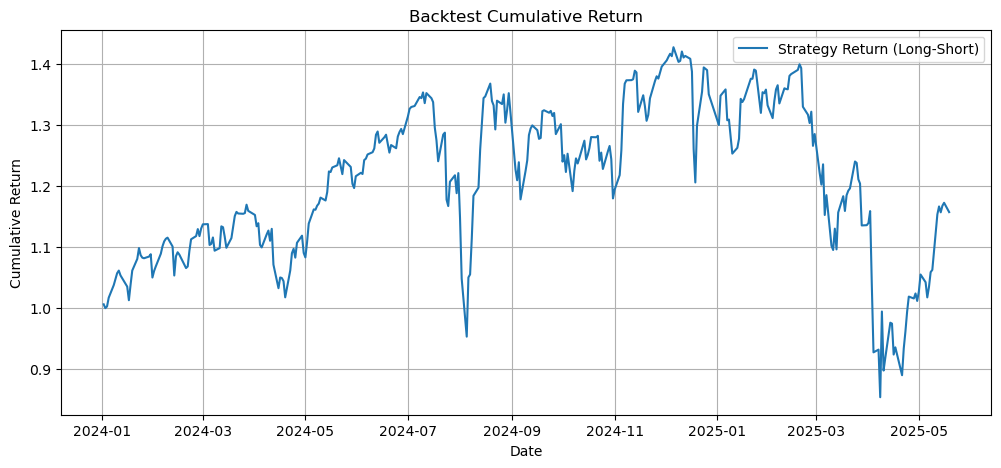

count    346.000000
mean       0.000843
std        0.028966
min       -0.106418
25%       -0.010089
50%        0.003569
75%        0.015262
max        0.164410
Name: Daily Return, dtype: float64


In [244]:
bt_result = backtest_long_short(forecast_df, testing_set, top_k=3)
bt_result.name = "Daily Return"

cumulative_return = (1 + bt_result).cumprod()
cumulative_return.name = "Cumulative Return"

print(cumulative_return)
plt.figure(figsize=(12, 5))
plt.plot(cumulative_return, label="Strategy Return (Long-Short)")
plt.title("Backtest Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.savefig("results/cumulative_returnfigure.png")
plt.show()

print(bt_result.describe())
bt_result.to_csv("results/var_backtest_returns.csv")
cumulative_return.to_csv("results/var_cumulative_return.csv")

### Backtest Result (2024-01 to 2025-05)
- Final cumulative return: **~1.15x**
- Strategy shows **reasonable predictive power** overall
- A few drawdowns occurred around:
  - **2024-08**: hedge fund deleveraging
  - **2025-02 to 03**: inflation & confidence shocks
  - **2025-04**: US tariff policy announcement
- Most losses appear **event-driven**, while model performance remains relatively stable outside these periods
- This is a simple **baseline strategy**, as I am still in the early stage of learning how to conduct backtesting



# Section TWO: XGBoost Regression (multi-factor model)

In this section, I apply an **XGBoost regression model** to predict ETF daily returns based on **multiple engineered features**.  

This is a more advanced **`ML-based approach`**.


## Step 1: Feature Engineering and Dataset Preparation

In this step, I construct multiple predictive features such as recent returns, rolling volatility, and momentum signals.  

All feature-target pairs are aligned by date and stored for supervised training.


### 1.1: Generate Rolling Features

For each ETF, I construct several rolling features based on historical price and volume data:

- `returns`: daily percentage change
- `vol_5d`: 5-day rolling volatility
- `mom_5d`: 5-day momentum ratio (price vs. 5-day average)
- `op_cl_diff`: difference between close and open price
- `vol_ratio`: current volume vs. 5-day average volume

Feature values are strictly aligned to ensure that data at **time T** does not incorporate any information from **time T+1**, preventing any form of data leakage.

In [40]:
def parse_volume(s):
    try:
        s = s.strip().upper()
        if s.endswith("M"):
            return float(s[:-1]) * 1e6
        elif s.endswith("K"):
            return float(s[:-1]) * 1e3
        else:
            return float(s)
    except:
        return None


csv_files = [f for f in os.listdir(ORIGINAL_DATA_DIR) if f.endswith(".csv")]
feature_list = []

for file in csv_files:
    etf = file.replace(".csv", "")
    df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, file), index_col="Date", parse_dates=True)

    df["Change %"] = df["Change %"].astype(str).str.replace("%", "").str.replace(",", "").astype(float) / 100
    df.loc[df["Change %"].abs() > 1, "Change %"] = None  # Cleaning
    df["Vol."] = df["Vol."].apply(parse_volume)

    for col in df.columns.difference(["Change %", "Vol."]):
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

    # Build rolling features
    ff = pd.DataFrame(index=df.index)
    ff[f"{etf}_returns"]     = df["Change %"]
    ff[f"{etf}_vol_5d"]      = df["Change %"].rolling(5).std()
    ff[f"{etf}_mom_5d"]      = (df["Price"] / df["Price"].rolling(5).mean())
    ff[f"{etf}_op_cl_diff"]  = (df["Price"] - df["Open"])
    ff[f"{etf}_vol_ratio"]   = (df["Vol."] / df["Vol."].rolling(5).mean())


    feature_list.append(ff)

# Combine all features
rolling_features = pd.concat(feature_list, axis=1)
rolling_features.to_csv("data/processed_data/rolling_features.csv")
print("Rolling features shape: ", rolling_features.shape)

Rolling features shape:  (3146, 80)


### 1.2: Add in lag features & Alignment 

To capture short-term historical patterns, I add 1 to 3-day lagged returns as additional features.  
The target is defined as the **next-day return**, shifted backward by one day.

All features and targets are strictly aligned to ensure:
- Lag features only use information available up to **time  T**
- Targets represent returns at **time T+1**
- Only valid dates with complete feature-target pairs are kept

This setup prevents any **look-ahead bias** and ensures proper supervised learning structure.

In [192]:
n_lag = 3
lag_features = []
return_df = pd.read_csv("data/processed_data/return_merged_df.csv", index_col = "Date", parse_dates = True)

for lag in range(1, n_lag + 1):
    lagged_df = return_df.shift(lag)
    lagged_df.columns = [f"{col}_lag{lag}" for col in return_df.columns]
    lag_features.append(lagged_df)

df_combination = pd.concat([rolling_features] + lag_features, axis = 1)
df_target = return_df.shift(-1)

valid_dates = df_combination.dropna().index.intersection(df_target.dropna().index)
xgb_features = df_combination.loc[valid_dates]
y_targets = df_target.loc[valid_dates]

xgb_features.to_csv("data/processed_data/xgb_features.csv")
y_targets.to_csv("data/processed_data/y_targets.csv")

print("XGBoost features shape:", xgb_features.shape)
print("Targets shape:", y_targets.shape)

XGBoost features shape: (1596, 128)
Targets shape: (1596, 16)


## Step 2: Hyperparameters Optimization (Optuna)

In this step, I train an **XGBoost regression model** for each ETF using optimized hyperparameters found **Bayesian optimization** (powered by Optuna).

- The objective is to minimize **RMSE** within a limited number of trials
- Training progress is **saved and reloadable** for each ETF
- **Optimization history** is plotted and saved for future reference

The output is a set of best hyperparameter dictionaries, one for each ETF model, to be used in the next training phase.

In [134]:
# Load feature and target data
x = pd.read_csv("data/processed_data/xgb_features.csv", index_col="Date", parse_dates=True)
y_target = pd.read_csv("data/processed_data/y_targets.csv", index_col="Date", parse_dates=True)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Split dates
optimization_end = pd.Timestamp("2023-12-31") # For Optuna optimization 
backtest_start = pd.Timestamp("2024-01-01")
backtest_end = pd.Timestamp("2025-05-19")

Optuna_x = x.loc[x.index <= optimization_end]
Optuna_y_target = y_target.loc[y_target.index <= optimization_end]

def optimize_hyperparas(etf_name, x_opt, y_opt, n_trials):
    print(f"\n--- Optimizing hyperparameters for {etf_name} with Optuna ---")
    y_current = y_opt[etf_name]
    training_split = int(len(x_opt) * 0.8)
    x_train, y_train = x_opt.iloc[:training_split], y_current.iloc[:training_split]
    x_test, y_test = x_opt.iloc[training_split:], y_current.iloc[training_split:]

    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric' : 'rmse',
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 200),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.05, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.05, 1.0),
            'random_state': 42
        }

        model = xgb.XGBRegressor(**params)

        model.fit(
            x_train, y_train,
        )

        y_pred = model.predict(x_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    study_dir = "optuna_study"
    os.makedirs(study_dir, exist_ok = True)
    study_path = os.path.join(study_dir, f"study_{etf_name}.pkl")

    if os.path.exists(study_path):
        try:
            study = joblib.load(study_path)
            print(f"Loaded existing Optuna study for {etf_name}")
        except Exception as e:
            print(f"Error loading study: {e}. Creating new study.")
            study = optuna.create_study(direction = 'minimize')
    else:
        study = optuna.create_study(direction = 'minimize')
        print(f"Created new Optuna study for {etf_name}")

    study.optimize(objective, n_trials = n_trials)

    print(f"\nBest parameters for {etf_name}:", study.best_params)
    print(f"Best RMSE for {etf_name}:", study.best_value)

    joblib.dump(study, study_path)
    print(f"Optuna study saved to: {study_path}")

    try:
        fig = plot_optimization_history(study)
        fig_path = os.path.join(study_dir, f"plot_{etf_name}.png")
        fig.write_image(fig_path)
        print(f"Optimization history plot saved to {fig_path}")
    except Exception as e:
        print(f"Failed to save optimization plot for {etf_name}: {e}")
    
    return study.best_params

etf_list = ['DIA', 'IWM', 'QQQ', 'SPY', 'VXX',
            'XLB', 'XLC', 'XLE', 'XLF', 'XLI',
            'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']

best_params_list = {}
for etf in etf_list:
    best_params = optimize_hyperparas(etf, Optuna_x, Optuna_y_target, n_trials = 5)
    best_params_list[etf] = best_params

print("\n All hyperparas optimazation done")


--- Optimizing hyperparameters for DIA with Optuna ---
Loaded existing Optuna study for DIA

Best parameters for DIA: {'max_depth': 4, 'learning_rate': 0.017088464360828087, 'n_estimators': 175, 'subsample': 0.7561179480417997, 'colsample_bytree': 0.7675269638283777, 'reg_alpha': 0.20439761184716754, 'reg_lambda': 0.8847696375060774}
Best RMSE for DIA: 0.005462672763716434
Optuna study saved to: optuna_study/study_DIA.pkl
Optimization history plot saved to optuna_study/plot_DIA.png

--- Optimizing hyperparameters for IWM with Optuna ---
Loaded existing Optuna study for IWM

Best parameters for IWM: {'max_depth': 3, 'learning_rate': 0.031511492412107586, 'n_estimators': 133, 'subsample': 0.9496739829217731, 'colsample_bytree': 0.9389539842083746, 'reg_alpha': 0.23963313986434148, 'reg_lambda': 0.12356288326373281}
Best RMSE for IWM: 0.00910924753307516
Optuna study saved to: optuna_study/study_IWM.pkl
Optimization history plot saved to optuna_study/plot_IWM.png

--- Optimizing hyperpar

## Step 3: XGBoost Model Training

Using the best hyperparameters found by Optuna, I train an **XGBoost model** for each ETF on the full in-sample dataset.

All predicted and true returns are saved for later backtesting and IC calculating.

In [136]:
train_x = x.loc[x.index <= optimization_end]
train_y_targets = y_target.loc[y_target.index <= optimization_end]

# Backtest data
backtest_x = x.loc[x.index >= backtest_start]
backtest_y_targets = y_target.loc[y_target.index >= backtest_start]

print(f"In-Sample Range: {train_x.index.min().date()} To {train_x.index.max().date()}")
print(f"Out-of-Sample Range: {backtest_x.index.min().date()} To {backtest_x.index.max().date()}")
print(f"In-Sample Shape: {train_x.shape}, Target Shape: {train_y_targets.shape}")
print(f"Out-of-Sample Shape: {backtest_x.shape}, Target Shape: {backtest_y_targets.shape}")

print("\n--- XGBoost Model Training ---")

in_sample_preds_df = pd.DataFrame(index = train_x.index)
out_of_sample_preds_df = pd.DataFrame(index = backtest_x.index)

results_dir = "results" 
os.makedirs(results_dir, exist_ok = True)

for etf in etf_list:
    print(f"\n  Training for {etf} and making predictions...")
    
    if etf not in best_params_list:
        print(f"Error: Best params for {etf} not found, skip")
        continue

    params = best_params_list[etf]
    
    y_train_etf = train_y_targets[etf]
    y_backtest_etf = backtest_y_targets[etf]

    model = xgb.XGBRegressor(**params, random_state = 42)
    model.fit(train_x, y_train_etf, verbose = False) 

    in_sample_preds_df[f"{etf}_pred"] = model.predict(train_x)
    in_sample_preds_df[f"{etf}_true"] = y_train_etf 

    out_of_sample_preds_df[f"{etf}_pred"] = model.predict(backtest_x)
    out_of_sample_preds_df[f"{etf}_true"] = y_backtest_etf

in_sample_preds_df.to_csv(os.path.join(results_dir, "in_sample_predictions.csv"))
out_of_sample_preds_df.to_csv(os.path.join(results_dir, "out_of_sample_predictions.csv"))

print(f"\nIn-Sample result has been saved in: {os.path.join(results_dir, 'in_sample_predictions.csv')}")
print(f"Out-of-Sample result has been saved in: {os.path.join(results_dir, 'out_of_sample_predictions.csv')}")

In-Sample Range: 2018-06-26 To 2023-12-29
Out-of-Sample Range: 2024-01-02 To 2025-05-13
In-Sample Shape: (1254, 128), Target Shape: (1254, 16)
Out-of-Sample Shape: (342, 128), Target Shape: (342, 16)

--- XGBoost Model Training ---

  Training for DIA and making predictions...

  Training for IWM and making predictions...

  Training for QQQ and making predictions...

  Training for SPY and making predictions...

  Training for VXX and making predictions...

  Training for XLB and making predictions...

  Training for XLC and making predictions...

  Training for XLE and making predictions...

  Training for XLF and making predictions...

  Training for XLI and making predictions...

  Training for XLK and making predictions...

  Training for XLP and making predictions...

  Training for XLRE and making predictions...

  Training for XLU and making predictions...

  Training for XLV and making predictions...

  Training for XLY and making predictions...

In-Sample result has been save

## Step 4: Evaluate In-sample and Out-of-sample Cross-Sectional IC
This step assesses the model's cross-sectional predictive power by computing the **Spearman correlation (IC)** between predicted and actual ETF returns across all ETFs **on each day**. 

I also report:

- The **average IC** over all days, as a summary of model ranking quality
- The **proportion of statistically significant ICs** (p < 0.05), indicating how often the model outperforms random ranking

Higher IC and significance ratio suggest stronger and more consistent cross-sectional predictive power.


In [198]:
import pandas as pd
from scipy.stats import spearmanr

# Load merged results from all ETF models
in_sample_df = pd.read_csv("results/in_sample_predictions.csv", index_col="Date", parse_dates=True)
out_of_sample_df = pd.read_csv("results/out_of_sample_predictions.csv", index_col="Date", parse_dates=True)

# Identify prediction and true value columns
pred_cols_in = [col for col in in_sample_df.columns if col.endswith("_pred")]
true_cols_in = [col for col in in_sample_df.columns if col.endswith("_true")]

pred_cols_out = [col for col in out_of_sample_df.columns if col.endswith("_pred")]
true_cols_out = [col for col in out_of_sample_df.columns if col.endswith("_true")]


# Function to compute IC and p-values for each day
def compute_cross_ic(df_subset, pred_cols_list, true_cols_list):
    ic_list = []
    p_list = []
    for date in df_subset.index:
        preds = df_subset.loc[date, pred_cols_list].values
        trues = df_subset.loc[date, true_cols_list].values
        if not pd.isnull(preds).any() and not pd.isnull(trues).any():
            ic, p = spearmanr(preds, trues)
            ic_list.append(ic)
            p_list.append(p)
    return ic_list, p_list

# Calculate ICs
ic_in, p_in = compute_cross_ic(in_sample_df, pred_cols_in, true_cols_in)
ic_out, p_out = compute_cross_ic(out_of_sample_df, pred_cols_out, true_cols_out)

ic_in = [x for x in ic_in if x is not None]
p_in = [x for x in p_in if x is not None]
ic_out = [x for x in ic_out if x is not None]
p_out = [x for x in p_out if x is not None]

# Evaluate performance
avg_ic_in = sum(ic_in) / len(ic_in)
sig_ratio_in = sum(p < 0.05 for p in p_in) / len(p_in)

avg_ic_out = sum(ic_out) / len(ic_out)
sig_ratio_out = sum(p < 0.05 for p in p_out) / len(p_out)

# Print results
print("\nIn-sample IC Evaluation")
print(f"Average in-sample cross-section IC: {avg_ic_in:.2f}")
print(f"Significant IC proportion (p < 0.05): {sig_ratio_in:.2%}")

print("\nOut-of-sample IC Evaluation")
print(f"Average out-of-sample cross-section IC: {avg_ic_out:.2f}")
print(f"Significant IC proportion (p < 0.05): {sig_ratio_out:.2%}")



In-sample IC Evaluation
Average in-sample cross-section IC: 0.58
Significant IC proportion (p < 0.05): 67.54%

Out-of-sample IC Evaluation
Average out-of-sample cross-section IC: 0.38
Significant IC proportion (p < 0.05): 42.11%


> ✅ The model achieves strong cross-sectional predictive performance:
> - Average in-sample IC: **0.58**, with 67.5% statistically significant days
> - Average out-of-sample IC: **0.38**, with 42.1% significant days

All feature construction and target alignment strictly avoid future information leakage.  
Lagged features and shifted targets are carefully handled to reflect only historical data available at prediction time.

(*However, the IC still feels slightly too high—I haven't identified the exact cause yet.*)

-----------------------------------------------------------------------------
Below are the visualizations of **daily in-sample and out-of-sample ICs**, highlighting average performance and day-to-day fluctuations.


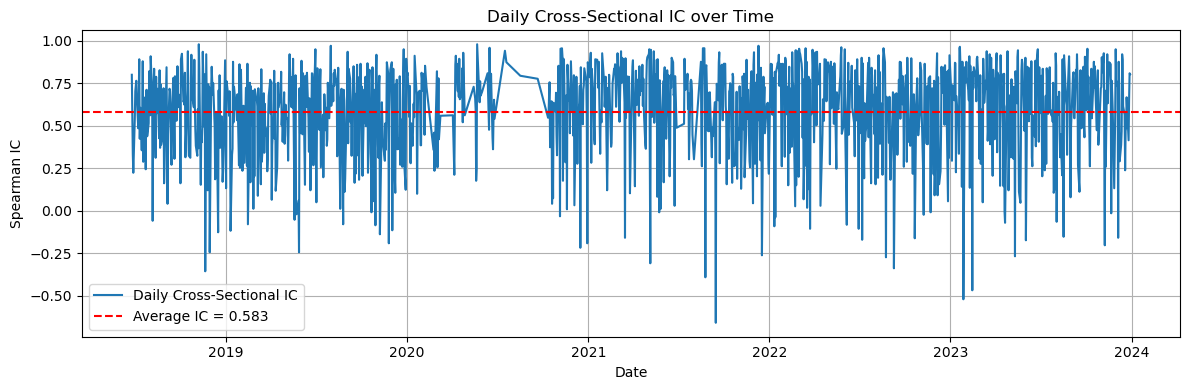

In [206]:
df = pd.read_csv("results/in_sample_predictions.csv", index_col = "Date", parse_dates = True)

pred_cols = [col for col in df.columns if col.endswith("_pred")]
true_cols = [col for col in df.columns if col.endswith("_true")]

ic_series = []
for date in df.index.unique():
    preds = df.loc[date, pred_cols]
    trues = df.loc[date, true_cols]
    
    if not preds.isnull().any() and not trues.isnull().any():
        ic, _ = spearmanr(preds.values, trues.values)
        ic_series.append((date, ic))

ic_df = pd.DataFrame(ic_series, columns = ["Date", "IC"]).set_index("Date")

# Daily Cross-Sectional IC
plt.figure(figsize = (12, 4))
plt.plot(ic_df.index, ic_df["IC"], label = "Daily Cross-Sectional IC")
plt.axhline(ic_df["IC"].mean(), color = 'red', linestyle = '--', label = f"Average IC = {ic_df['IC'].mean():.3f}")
plt.title("Daily Cross-Sectional IC over Time")
plt.xlabel("Date")
plt.ylabel("Spearman IC")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

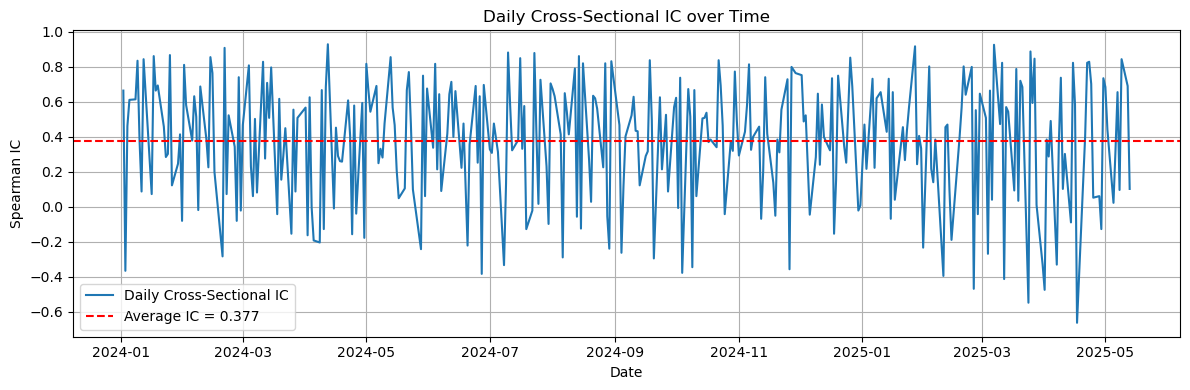

In [208]:
df = pd.read_csv("results/out_of_sample_predictions.csv", index_col = "Date", parse_dates = True)

pred_cols = [col for col in df.columns if col.endswith("_pred")]
true_cols = [col for col in df.columns if col.endswith("_true")]

ic_series = []
for date in df.index.unique():
    preds = df.loc[date, pred_cols]
    trues = df.loc[date, true_cols]
    
    if not preds.isnull().any() and not trues.isnull().any():
        ic, _ = spearmanr(preds.values, trues.values)
        ic_series.append((date, ic))

ic_df = pd.DataFrame(ic_series, columns = ["Date", "IC"]).set_index("Date")

# Daily Cross-Sectional IC
plt.figure(figsize = (12, 4))
plt.plot(ic_df.index, ic_df["IC"], label = "Daily Cross-Sectional IC")
plt.axhline(ic_df["IC"].mean(), color = 'red', linestyle = '--', label = f"Average IC = {ic_df['IC'].mean():.3f}")
plt.title("Daily Cross-Sectional IC over Time")
plt.xlabel("Date")
plt.ylabel("Spearman IC")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Step 5: Backtest Based on XGBoost Predictions

Using the out-of-sample predictions from the XGBoost models,  
I simulate a **daily long-short strategy** from 2024-01-01 to 2025-05-19:

- Go **long** on the top 3 ETFs with the highest predicted returns  
- Go **short** on the bottom 3 ETFs  
- Return is calculated as:  
  `0.5 × average long return − 0.5 × average short return`

The strategy’s daily and cumulative returns are visualized and summarized for performance evaluation.

In [210]:
results_dir = "results" 
try:
    combined_df = pd.read_csv(os.path.join(results_dir, "out_of_sample_predictions.csv"), index_col="Date", parse_dates=True)
    print(f"Loading backtest data success. Date range: {combined_df.index.min().date()} To {combined_df.index.max().date()}")
except FileNotFoundError:
    print(f"Error: Fail to find {os.path.join(results_dir, 'out_of_sample_predictions.csv')}")
    exit()

all_pred_cols = [col for col in combined_df.columns if col.endswith("_pred")]
all_true_cols = [col for col in combined_df.columns if col.endswith("_true")]

all_pred_cols.sort()
all_true_cols.sort()

forecast_df = combined_df[all_pred_cols].copy()
forecast_df.columns = [col.replace('_pred', '') for col in all_pred_cols]

actual_df = combined_df[all_true_cols].copy()
actual_df.columns = [col.replace('_true', '') for col in all_true_cols]

print(f"Forecast_df Shape: {forecast_df.shape}")
print(f"Actual_df Shape: {actual_df.shape}")

Loading backtest data success. Date range: 2024-01-02 To 2025-05-13
Forecast_df Shape: (342, 16)
Actual_df Shape: (342, 16)


Date
2024-01-02     1.014845
2024-01-03     1.013136
2024-01-04     1.018792
2024-01-05     1.030029
2024-01-08     1.036013
                ...    
2025-05-07    11.893706
2025-05-08    11.900120
2025-05-09    12.437867
2025-05-12    12.579161
2025-05-13    12.558216
Length: 342, dtype: float64


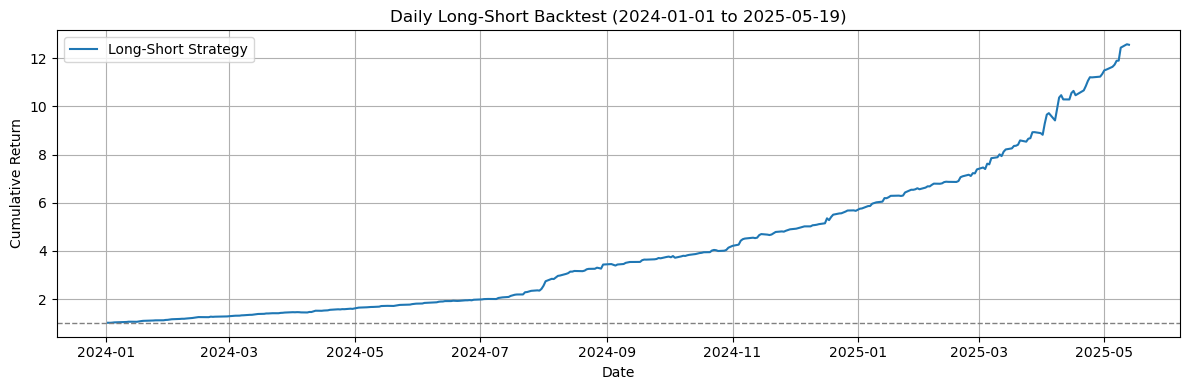

count    342.000000
mean       0.007488
std        0.011288
min       -0.031005
25%        0.000966
50%        0.005766
75%        0.011119
max        0.072744
dtype: float64


In [149]:
def xgb_backtest_long_short(forecast_df, actual_df, top_k):
    daily_returns = []
    
    dates = forecast_df.index.intersection(actual_df.index).unique()
    etfs = forecast_df.columns.intersection(actual_df.columns)

    if len(dates) == 0 or len(etfs) < top_k * 2:
        print("Warning: The predictions or actual data are insufficient for backtesting")
        return pd.Series([0], index=[dates[0]] if len(dates) > 0 else [pd.Timestamp.now()])

    for date in dates:
        preds_t = forecast_df.loc[date, etfs]
        trues_t = actual_df.loc[date, etfs]

        temp_combined = pd.DataFrame({'pred': preds_t, 'true': trues_t}).dropna()
        top_k_etfs = temp_combined['pred'].sort_values(ascending = False).head(top_k).index
        bottom_k_etfs = temp_combined['pred'].sort_values(ascending = True).head(top_k).index

        long_ret = temp_combined.loc[top_k_etfs, 'true'].mean()
        short_ret = temp_combined.loc[bottom_k_etfs, 'true'].mean()

        strategy_return = 0.5 * long_ret - 0.5 * short_ret
        daily_returns.append(strategy_return)

    return pd.Series(daily_returns, index = dates[:len(daily_returns)])


xgb_bt_result = xgb_backtest_long_short(forecast_df, actual_df, top_k = 3)

if not bt_result.empty:
    xgb_cumulative_return = (1 + bt_result).cumprod()
else:
    xgb_cumulative_return = pd.Series([1.0], index=[pd.Timestamp("2024-01-01")])

print(xgb_cumulative_return)

plt.figure(figsize = (12, 4))
plt.plot(cumulative_return.index, cumulative_return, label = "Long-Short Strategy")
plt.axhline(1, color = "gray", linestyle = "--", linewidth = 1)
plt.title("Daily Long-Short Backtest (2024-01-01 to 2025-05-19)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(bt_result.describe())

### Backtest Result (2024-01 to 2025-05)

- **Final cumulative return**: ~**12.5x**
- The XGBoost-based strategy demonstrates **strong and consistent predictive power**, with stable upward performance.
- Compared to the VAR baseline, this strategy achieves significantly higher returns and better risk control.
- Note: **Transaction costs and slippage are not included**, so actual performance may be moderately lower.
Still, this is an early-stage implementation, and further validation is needed to ensure robustness across different timeframes and market regimes